In [18]:
import math
import numpy as np
from mmfutils.performance.fft import fftn, ifftn
from pytimeode import interfaces, mixins, evolvers
import State2Coupled
reload(State2Coupled)
from State2Coupled import State2, u

Populating the interactive namespace from numpy and matplotlib


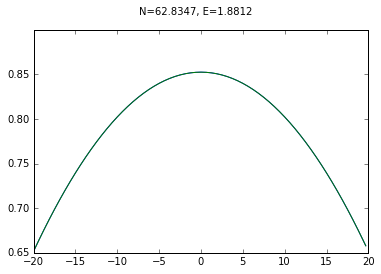

In [19]:
%pylab inline --no-import-all
from IPython.display import display, clear_output
s = State2(Nxyz=(128,), Lxyz=(40*u.micron,),ws = np.array([26.0, ])*u.Hz, N=1e5)
s.plot()

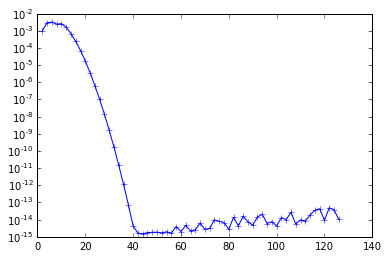

In [20]:
def get_err(N=128, L=24*u.micron):
    s = State2(Nxyz=(N,), Lxyz=(L,), N=1e5)
    s.g11=s.g22=s.g12=s.RabiFrequency=0
    a = np.sqrt(u.hbar/u.m/s.ws[0])
    x = s.xyz[0]
    psi_0 = np.exp(-(x/a)**2/2.0)
    s[...] = psi_0
    s.normalize()
    dy = s.empty()
    s.compute_dy_dt(dy=dy, subtract_mu=True)
    return abs(dy[...]).max()
Ns = np.arange(2,128,2)
errs = map(get_err, Ns)
plt.semilogy(Ns, errs, '+-')

In [21]:
s = State2(Nxyz=(46,), Lxyz=(23*u.micron,))
a = np.sqrt(u.hbar/u.m/s.ws[0])
L, N = s.Lxyz[0], s.Nxyz[0]
k_max = np.pi*(N-2)/L   # For Khalid...
print (k_max, s.kxyz[0].max())
print(np.exp(-(L/2/a)**2/2))   # Wavefunction drops by factor of macheps

(6.010003337302212, 6.010003337302213)
9.87009441159e-15


In [22]:
%pylab inline --no-import-all
from IPython.display import display, clear_output
import States
from States import State, u
s = State(Nxyz=(64,), Lxyz=(23*u.micron,), N=1e5)
a = np.sqrt(u.hbar/u.m/s.ws[0])
x = s.xyz[0]
psi_0 = np.exp(-(x/a)**2/2)
class State1(State2):
    def __init__(self, *v, **kw):
        State.__init__(self, *v, **kw)
        a = np.sqrt(u.hbar/u.m/self.ws[0])
        x = self.xyz[0]
        k = 1./2./a**2
        psi_0 = 4.0*np.exp(-(x/a)**2/2)
        n_0 = abs(psi_0)**2
        self._V_ext = (u.hbar**2/2.0/u.m*(4*(k*x)**2 - 2*k) - self.g*n_0)
        self.data[...] = psi_0
        self.get_Vext = lambda: self._V_ext
        self.pre_evolve_hook()

Populating the interactive namespace from numpy and matplotlib


1.2867553465376567

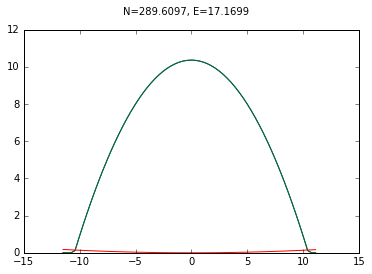

In [23]:
s = State2(Nxyz=(64,), Lxyz=(23*u.micron,))
s.plot()
plt.plot(x, s.get_Vext())
dy = s.empty()
s.compute_dy_dt(dy=dy, subtract_mu=False)
abs(dy[...]).max()

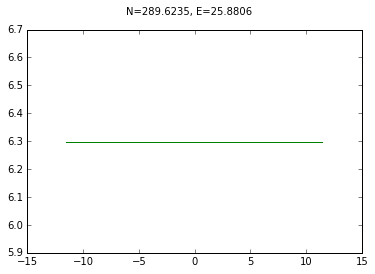

In [24]:
from mmfutils.contexts import NoInterrupt
from pytimeode.evolvers import EvolverSplit, EvolverABM
from IPython.display import display, clear_output

s = State2(Nxyz=(64*4,), Lxyz=(23*u.micron,))
assert np.allclose(s._N, s.get_N())
s[0] = 1.0
s[1] = 1.0
s.normalize()
s.cooling_phase = 1j
E_max = u.hbar**2*np.abs(s.kxyz).max()**2/2.0/u.m
e = EvolverABM(s, dt=0.0001*u.hbar/E_max, normalize=True)
e.y.plot()

In [25]:
s.get_CouplingTerm();

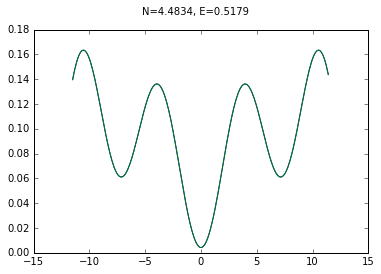

In [26]:
dy = s.empty()
dy = s.compute_dy_dt(dy)
dy.plot()

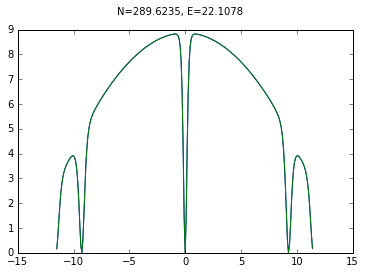

In [33]:
s.cooling_phase = 1j
s.barrierFlag = False
s.RabiFrequency=6
#s.g22 = 0.55 * 4 * np.pi * u.hbar**2 * u.a/u.m
e = EvolverABM(s, dt=0.01*u.hbar/E_max, normalize=False)
with NoInterrupt(ignore=True) as interrupted:
    while e.y.t < 4*u.ms and not interrupted:
        e.evolve(100)
        #print(e.y.get_N())
        plt.clf()
        e.y.plot()
        display(plt.gcf())
        clear_output(wait=True)

In [0]:
%debug

In [0]:
s.braket(s[...],s[...])
s[...].shape

In [0]:
b=s.get_Barrier(20)
s.barrierFlag=False
plt.plot(s.xyz[0],s.get_V()[0])

In [0]:
e.y.cooling_phase = 1
e.y.barrierFlag = True
e.y.t = 0
#e.y.g22 = 0.75 * e.y.g11
e.y.g12 = 0
e.y.barrierOffset = -3.5
e.y.barrierIntensity = 10.0
e.y.barrierWidth = np.array([0.3,])
e.y.barrierVelocity = np.array([.175,])
with NoInterrupt(ignore=True) as interrupted:
    while e.y.t < u.ms and not interrupted:
        e.evolve(100)
        plt.clf()
        e.y.plot()
        plt.plot(e.y.xyz[0],e.y.get_V()[0])
        display(plt.gcf())
        clear_output(wait=True)